# Project Twitter Sentiment Analysis (Donald Trump Tweets)

### Import necessary packages and utilities

In [1]:
import tweepy
from tweepy import OAuthHandler
import pandas as pd
import numpy as np

In [2]:
# Enter API keys from Twitter Developer Console
consumer_key = consumer_secret = 
access_token = access_secret = 

In [10]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

In [4]:
#Creating a DataFrame of most recent retrievable tweets by Donald Trump

In [9]:
#Using tweet_mode set to "extended" we can retrieve complete tweet version, not just a truncated version.

In [5]:
df_trump_tweets = pd.DataFrame()
for page in range(1,15):
    trump_tweets = api.user_timeline('realDonaldTrump', page = page, count = 200, tweet_mode="extended")
    for tweet in trump_tweets:
        curr_tweet = {
            'text': tweet.full_text,
            'likes': tweet.favorite_count,
            'retweets': tweet.retweet_count,
            'created_at':tweet.created_at,
            'source':tweet.source
        }
        df_trump_tweets = df_trump_tweets.append(curr_tweet, ignore_index = True)
df_trump_tweets

,created_at,likes,retweets,source,text
0,2020-02-20 19:58:54,0.0,2064.0,Twitter for iPhone,RT @WhiteHouse: LIVE: President @realDonaldTru...
1,2020-02-20 18:24:04,40237.0,8004.0,Twitter for iPhone,“The real winner last night was Donald Trump.”...
2,2020-02-20 18:18:01,28811.0,8657.0,Twitter for iPhone,“The decision not to prosecute Andy McCabe is ...
3,2020-02-20 17:13:42,55813.0,11979.0,Twitter for iPhone,“I don’t think there’s any chance whatsoever o...
4,2020-02-20 15:29:18,72611.0,20635.0,Twitter for iPhone,John Kerry and Senator Chris Murphy grossly vi...
...,...,...,...,...,...
1393,2019-11-24 19:14:49,0.0,5950.0,Twitter for iPhone,RT @DailyCaller: .@ewarren lies about the fact...
1394,2019-11-24 19:14:07,33018.0,8120.0,Twitter for iPhone,But I did nothing wrong. Read the Transcripts ...
1395,2019-11-24 19:10:59,34386.0,8543.0,Twitter for iPhone,100% Correct! https://t.co/VJfkmaraGV
1396,2019-11-24 19:09:34,0.0,2239.0,Twitter for iPhone,RT @RepRobertHurt: Great to have my brother @c...


In [17]:
# Filtering tweets that are only by Donald Trump in order to perform sentiment analysis appropriately

In [18]:
user_tweets = []
retweets = []
for tweet in df_trump_tweets.text:
    if tweet.startswith('RT'):
        retweets.append(tweet)
    else:
        user_tweets.append(tweet)
print(f"Number of retweeted tweets: {len(retweets)}")
print(f"Number of tweets by Donald Trump: {len(user_tweets)}")

Number of retweeted tweets: 862
Number of tweets by Donald Trump: 536


In [19]:
#For the purpose of sentiment analysis it is more suitable to work on tweets that are actually tweeted by the user.
#We can also see that we have retrieved complete text for each tweet.
user_tweets[3]

'John Kerry and Senator Chris Murphy grossly violated the Logan Act with respect to Iran. If a Republican did what they did, there would be very serious ramifications!'

### Text Preprocessing for Machine Learning

In case of Sentiment Analysis removing Stopwords is not always a good idea as it might alter the meaning of the sentence leading to variations in the meaning of the sentence. But for the purpose of creating a n-gram model it is rather useful.

In [61]:
trump_tweets = pd.DataFrame(user_tweets)
trump_tweets.rename(columns={0:'text'},inplace=True)
trump_tweets.head(5)

,text
0,“The real winner last night was Donald Trump.”...
1,“The decision not to prosecute Andy McCabe is ...
2,“I don’t think there’s any chance whatsoever o...
3,John Kerry and Senator Chris Murphy grossly vi...
4,“They say Roger Stone lied to Congress.” @CNN ...


In [62]:
# Step 1: Convert evrything to lower case characters

trump_tweets['text'] = trump_tweets['text'].str.lower()
trump_tweets.head()

,text
0,“the real winner last night was donald trump.”...
1,“the decision not to prosecute andy mccabe is ...
2,“i don’t think there’s any chance whatsoever o...
3,john kerry and senator chris murphy grossly vi...
4,“they say roger stone lied to congress.” @cnn ...


In [63]:
#Step 2: Remove punctuations

trump_tweets['clean_text'] = trump_tweets['text'].str.replace('[^a-z ]', "")
trump_tweets.head()

,text,clean_text
0,“the real winner last night was donald trump.”...,the real winner last night was donald trump mi...
1,“the decision not to prosecute andy mccabe is ...,the decision not to prosecute andy mccabe is u...
2,“i don’t think there’s any chance whatsoever o...,i dont think theres any chance whatsoever of s...
3,john kerry and senator chris murphy grossly vi...,john kerry and senator chris murphy grossly vi...
4,“they say roger stone lied to congress.” @cnn ...,they say roger stone lied to congress cnn oh ...


In [64]:
#step 3: Remove stopwords

from nltk.corpus import stopwords

stop = set(stopwords.words("english"))
def stop_word_rem(text):
    text = [word for word in text.split() if word not in stop]
    return " ".join(text)

trump_tweets['split_words'] = trump_tweets['clean_text'].apply(stop_word_rem)
trump_tweets.head()

,text,clean_text,split_words
0,“the real winner last night was donald trump.”...,the real winner last night was donald trump mi...,real winner last night donald trump mini mike ...
1,“the decision not to prosecute andy mccabe is ...,the decision not to prosecute andy mccabe is u...,decision prosecute andy mccabe utterly inexpli...
2,“i don’t think there’s any chance whatsoever o...,i dont think theres any chance whatsoever of s...,dont think theres chance whatsoever senator sa...
3,john kerry and senator chris murphy grossly vi...,john kerry and senator chris murphy grossly vi...,john kerry senator chris murphy grossly violat...
4,“they say roger stone lied to congress.” @cnn ...,they say roger stone lied to congress cnn oh ...,say roger stone lied congress cnn oh see comey...


### Unigram model

In [65]:
# Creating the count vectorizer

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

unigram_count_vect = CountVectorizer()

# Fitting on trump_tweets['split_words']

unigram_count_vect.fit(trump_tweets['split_words'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [66]:
# Creating a Document Term Matrix

Z = unigram_count_vect.fit_transform(trump_tweets['split_words'])
Z

<536x2611 sparse matrix of type '<class 'numpy.int64'>'
	with 7030 stored elements in Compressed Sparse Row format>

In [67]:
# Displaying the Document Term matrix

DTM_unigram = pd.DataFrame(Z.toarray(), columns=unigram_count_vect.get_feature_names())
DTM_unigram.head()

,able,abortion,absolutely,abuse,abusive,accepting,accomplish,accord,account,accusing,...,yesterday,yet,york,young,youre,youve,yucca,zelensky,zero,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
# Creating a frequency table from this DTM

word_count_freq_unigram = DTM_unigram.sum()
word_table_unigram = pd.DataFrame(word_count_freq_unigram).reset_index()
word_table_unigram = word_table_unigram.rename(columns={'index':'Word', 0:'Count'})
word_table_unigram.sort_values(by = 'Count', ascending=False).head(10)

,Word,Count
89,amp,105
875,great,104
1847,president,64
1222,impeachment,62
534,democrats,57
2335,thank,55
1669,nothing,52
1766,people,41
956,hoax,40
1644,never,39


### Bigram model

In [69]:
# Creating the count vectorizer

bigram_count_vect = CountVectorizer(ngram_range=(2,2))

# Fitting on trump_tweets['split_words']

bigram_count_vect.fit(trump_tweets['split_words'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(2, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [70]:
# Creating a Document Term Matrix

Z = bigram_count_vect.fit_transform(trump_tweets['split_words'])
Z

<536x5957 sparse matrix of type '<class 'numpy.int64'>'
	with 6817 stored elements in Compressed Sparse Row format>

In [71]:
# Displaying the Document Term matrix

DTM_bigram = pd.DataFrame(Z.toarray(), columns=bigram_count_vect.get_feature_names())
DTM_bigram.head()

,able devote,able fix,able properly,able see,able win,abortion socialism,absolutely decimated,absolutely hammered,absolutely nothing,absolutely pressure,...,zelensky proof,zelensky said,zelensky united,zero credibility,zero evidence,zero fed,zero presence,zero republican,zero sense,zuckerberg recently
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
# Creating a frequency table from this DTM

word_count_freq_bigram = DTM_bigram.sum()
word_table_bigram = pd.DataFrame(word_count_freq_bigram).reset_index()
word_table_bigram = word_table_bigram.rename(columns={'index':'Word', 0:'Count'})
word_table_bigram.sort_values(by = 'Count', ascending=False).head(10)

,Word,Count
2548,impeachment hoax,31
4411,republican party,20
3674,nothing democrats,20
5461,united states,18
1755,fake news,17
3393,mini mike,16
4240,radical left,15
5767,witch hunt,13
4277,read transcripts,12
4114,president trump,12


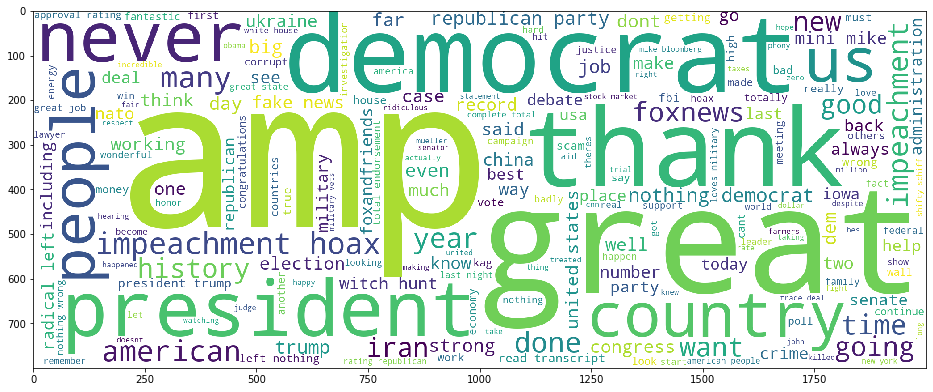

In [73]:
#Generating a wordcloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt
wc = WordCloud(background_color = 'White', height=800, width=2000).generate(" ". join(trump_tweets['split_words']))
plt.figure(figsize=(16,12))
plt.imshow(wc)

### Sentiment Analysis using TextBlob

In [74]:
from textblob import TextBlob

In [75]:
#Performing Sentiment Analysis on original tweets by Donald Trump.

def scores(text):
    return TextBlob(text).sentiment.polarity

trump_tweets['polarity_scores'] = trump_tweets['text'].apply(scores)
trump_tweets.head()

,text,clean_text,split_words,polarity_scores
0,“the real winner last night was donald trump.”...,the real winner last night was donald trump mi...,real winner last night donald trump mini mike ...,0.100000
1,“the decision not to prosecute andy mccabe is ...,the decision not to prosecute andy mccabe is u...,decision prosecute andy mccabe utterly inexpli...,-0.600000
2,“i don’t think there’s any chance whatsoever o...,i dont think theres any chance whatsoever of s...,dont think theres chance whatsoever senator sa...,0.114583
3,john kerry and senator chris murphy grossly vi...,john kerry and senator chris murphy grossly vi...,john kerry senator chris murphy grossly violat...,-0.270833
4,“they say roger stone lied to congress.” @cnn ...,they say roger stone lied to congress cnn oh ...,say roger stone lied congress cnn oh see comey...,-0.071875


In [76]:
# Categorizing the Polarity Range

sentiment_mapping = {1:'Strong Negative',
                    2:'Negative',
                    3:'Neutral',
                    4:'Positive',
                    5:'Strong Positive'}

map_sentiment = lambda x: np.digitize(x, [-1, -0.8, -0.25, 0.25, 0.8])


In [77]:
trump_tweets['sentiment_category'] = trump_tweets['polarity_scores'].apply(map_sentiment)

#Labeling the sentiment category

trump_tweets['label'] = trump_tweets['sentiment_category'].map(sentiment_mapping)

trump_tweets.head()

,text,clean_text,split_words,polarity_scores,sentiment_category,label
0,“the real winner last night was donald trump.”...,the real winner last night was donald trump mi...,real winner last night donald trump mini mike ...,0.100000,3,Neutral
1,“the decision not to prosecute andy mccabe is ...,the decision not to prosecute andy mccabe is u...,decision prosecute andy mccabe utterly inexpli...,-0.600000,2,Negative
2,“i don’t think there’s any chance whatsoever o...,i dont think theres any chance whatsoever of s...,dont think theres chance whatsoever senator sa...,0.114583,3,Neutral
3,john kerry and senator chris murphy grossly vi...,john kerry and senator chris murphy grossly vi...,john kerry senator chris murphy grossly violat...,-0.270833,2,Negative
4,“they say roger stone lied to congress.” @cnn ...,they say roger stone lied to congress cnn oh ...,say roger stone lied congress cnn oh see comey...,-0.071875,3,Neutral


In [78]:
#Check what labels the sentiments belong to 

trump_tweets['label'].value_counts()

Neutral            326
Positive           127
Strong Positive     48
Negative            32
Strong Negative      3
Name: label, dtype: int64

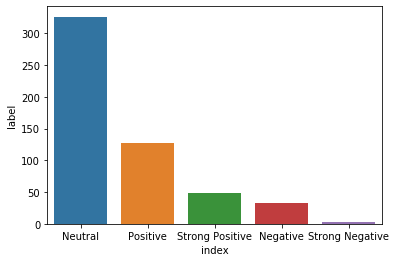

In [123]:
import seaborn as sns
sentiment_df = pd.DataFrame(trump_tweets['label'].value_counts()).reset_index()
sns.barplot(x=sentiment_df['index'], y=sentiment_df['label'])

### VADER Sentiment Analysis

In [79]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sentiment = SentimentIntensityAnalyzer()

In [84]:
trump_tweets_copy = pd.DataFrame(user_tweets).rename(columns={0:"text"})
trump_tweets_copy.head()

,text
0,“The real winner last night was Donald Trump.”...
1,“The decision not to prosecute Andy McCabe is ...
2,“I don’t think there’s any chance whatsoever o...
3,John Kerry and Senator Chris Murphy grossly vi...
4,“They say Roger Stone lied to Congress.” @CNN ...


In [85]:
text_polar = lambda x: sentiment.polarity_scores(x)['compound']
trump_tweets_copy['polarity_scores'] = trump_tweets_copy['text'].apply(text_polar)
trump_tweets_copy.head()

,text,polarity_scores
0,“The real winner last night was Donald Trump.”...,0.7644
1,“The decision not to prosecute Andy McCabe is ...,0.3089
2,“I don’t think there’s any chance whatsoever o...,0.7901
3,John Kerry and Senator Chris Murphy grossly vi...,-0.4740
4,“They say Roger Stone lied to Congress.” @CNN ...,-0.8147


In [86]:
# Categorizing the Polarity Range

sentiment_mapping = {1:'Strong Negative',
                    2:'Negative',
                    3:'Neutral',
                    4:'Positive',
                    5:'Strong Positive'}

map_sentiment = lambda x: np.digitize(x, [-1, -0.8, -0.25, 0.25, 0.8])

In [87]:
trump_tweets_copy['sentiment_category'] = trump_tweets_copy['polarity_scores'].apply(map_sentiment)

#Labeling the sentiment category

trump_tweets_copy['label'] = trump_tweets_copy['sentiment_category'].map(sentiment_mapping)

trump_tweets_copy.head()

,text,polarity_scores,sentiment_category,label
0,“The real winner last night was Donald Trump.”...,0.7644,4,Positive
1,“The decision not to prosecute Andy McCabe is ...,0.3089,4,Positive
2,“I don’t think there’s any chance whatsoever o...,0.7901,4,Positive
3,John Kerry and Senator Chris Murphy grossly vi...,-0.4740,2,Negative
4,“They say Roger Stone lied to Congress.” @CNN ...,-0.8147,1,Strong Negative


In [88]:
#Check what labels the sentiments belong to 

trump_tweets_copy['label'].value_counts()

Positive           174
Neutral            140
Negative           104
Strong Positive     89
Strong Negative     29
Name: label, dtype: int64

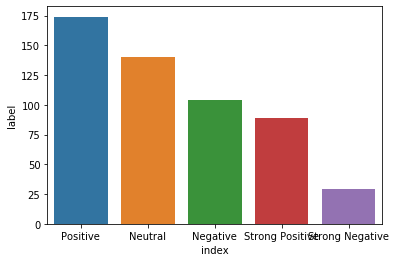

In [124]:
import seaborn as sns
sentiment_df = pd.DataFrame(trump_tweets_copy['label'].value_counts()).reset_index()
sns.barplot(x=sentiment_df['index'], y=sentiment_df['label'])